In [2]:
import os 
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
import fastai
print(fastai.__version__)

from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *
import torch
import pandas as pd

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1.0.61


In [4]:
main_path = "C:/Users/skmoon/Desktop/DACON_GROWTH"
train_imgs = glob(main_path+"/train/*/*/*.png") + glob(main_path+"/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path+"/test/image/*.png") + glob(main_path+"/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path+"/train/*/meta/*.csv")
train_label = glob(main_path+"/train/*/*.csv")
test_data = glob(main_path+"/test/meta/*.csv")
preprocessing_train_imgs = "C:/Users/skmoon/Desktop/DACON_GROWTH/PREPROCESSING-TRAIN"
preprocessing_test_imgs = "C:/Users/skmoon/Desktop/DACON_GROWTH/PREPROCESSING-TEST"
if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)


In [17]:
for i in tqdm(train_imgs):
    name = i.split("\\")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(preprocessing_train_imgs,name), img)

for i in tqdm(test_imgs):
    name = i.split("\\")[-1]
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(preprocessing_test_imgs,name), img)

100%|██████████| 460/460 [01:48<00:00,  4.25it/s]


In [5]:
train_df = []
for i, j in tqdm(zip(train_data, train_imgs)):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(f"C:/Users/skmoon/Desktop/DACON_GROWTH/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    df = df.fillna(0.0)
    '''
    정량이 정해져 있음 bbfill, ffill (LED, 분무량)
    정량이 정해져 있지 않음 interpolate (그외)
    '''
    df = df.mean()
    df = df.to_frame().T

    df["이미지"] = j.split("\\")[-1]

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df.head()

1592it [00:43, 36.80it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지
0,22.236181,43.868542,77.740695,4.676042,487.226389,19.594792,0.0,200.720833,201.000000,0.139583,17.416635,179.460356,18.854103,10.228598,145.944829,12.396061,21.119466,0.0,49.193,CASE01_01.png
1,23.011319,44.573750,77.645972,4.537500,480.144444,20.855555,0.0,200.861111,200.861111,0.139583,17.416462,179.471631,18.853965,13.709128,145.980283,12.391464,21.099885,0.0,59.764,CASE01_02.png
2,22.931111,39.537708,77.514931,4.886111,489.068750,20.748611,0.0,200.720833,200.443056,0.139583,17.416667,179.523570,18.854171,13.348331,146.015736,12.374227,21.133608,0.0,72.209,CASE01_03.png
3,21.027986,58.497500,80.069930,3.908333,481.378472,18.195278,0.0,200.025000,200.163889,0.139583,17.416674,179.495845,18.854174,7.520480,145.997472,12.370205,21.128169,0.0,85.737,CASE01_04.png
4,21.874305,67.058819,81.349792,3.908333,490.568750,19.400486,0.0,200.861111,201.000000,0.139583,17.416641,179.488241,18.854140,10.943552,145.971688,12.394912,21.121642,0.0,102.537,CASE01_05.png


In [12]:
test_df = []
for i, j in tqdm(zip(test_data, test_imgs)):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    df = df.fillna(0.0)

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = j.split("\\")[-1]

    test_df.append(df)
    
test_df = pd.concat(test_df, ignore_index=True)
test_df.head()

460it [00:08, 53.06it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,6120.690250,47.193750,7.484722,13.486806,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001.png
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,650.293681,33.498611,9.508333,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002.png
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,110.823069,47.191667,7.487500,13.477083,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003.png
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,6324.772167,47.187500,7.483333,13.479167,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004.png
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,6478.004611,47.188194,7.465972,13.478472,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005.png


In [13]:
data_path = Path("./")

In [14]:
# extremely unbalanced dataset, most of the images are benign
train_df["무게"].value_counts(normalize=True)
tfms = get_transforms(flip_vert=True)
size = 256
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

318

In [15]:
data_path

WindowsPath('.')

In [ ]:
# # load image data using train_df and prepare fastai LabelLists

# image_data = (ImageList.from_folder(data_path/"PREPROCESSING-TRAIN", extensions=[".png", ".jpg"])
#                .split_by_idx(val_idx)
#               .label_from_lists(train_df)
#               )
# image_data.train[0]


In [16]:
# load image data using train_df and prepare fastai LabelLists

image_data = (ImageList.from_df(train_df, path=data_path, cols="이미지",
                               folder="PREPROCESSING-TRAIN")
              .split_by_idx(val_idx)
              .label_from_df(cols="무게")
              .transform(tfms, size=size))

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=data_path, cols="이미지",
                                    folder="PREPROCESSING-TEST")
image_data.add_test(test_image_data)

c:\Users\skmoon\Desktop\Virtual\.venv\lib\site-packages\fastai\vision\transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


LabelLists;

Train: LabelList (1274 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
49.193,85.737,156.149,174.931,187.523
Path: .;

Valid: LabelList (318 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
31.241,302.911,4.222,169.959,169.785
Path: .;

Test: LabelList (460 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: .

49.193


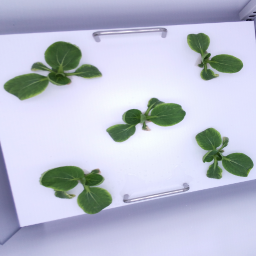

In [17]:
# show one example image
print(image_data.train[0][1])
image_data.train[0][0]

In [18]:
dep_var = '무게'
cont_names = ['내부온도관측치',	'외부온도관측치',	'내부습도관측치',	'외부습도관측치',	'CO2관측치',	'EC관측치',	'최근분무량',	'화이트 LED동작강도',	'레드 LED동작강도',	'블루 LED동작강도',	'냉방온도',	'냉방부하',	'난방온도',	'난방부하',	'총추정광량',	'백색광추정광량',	'적색광추정광량',	'청색광추정광량']
procs = [FillMissing, Categorify, Normalize]

In [19]:
tab_data = (TabularList.from_df(train_df, path=data_path, cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

# add test
tab_data.add_test(TabularList.from_df(test_df, cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (1274 items)
x: TabularList
내부온도관측치 0.0600; 외부온도관측치 2.0522; 내부습도관측치 0.9475; 외부습도관측치 -1.3070; CO2관측치 0.4416; EC관측치 8.7748; 최근분무량 -0.4863; 화이트 LED동작강도 6.3013; 레드 LED동작강도 8.9661; 블루 LED동작강도 -0.5290; 냉방온도 -0.1454; 냉방부하 7.5596; 난방온도 0.1813; 난방부하 2.1974; 총추정광량 0.1641; 백색광추정광량 -1.4222; 적색광추정광량 0.4667; 청색광추정광량 -0.5382; ,내부온도관측치 -0.0594; 외부온도관측치 3.3975; 내부습도관측치 1.0344; 외부습도관측치 -1.3422; CO2관측치 0.4117; EC관측치 8.1062; 최근분무량 -0.4863; 화이트 LED동작강도 6.2746; 레드 LED동작강도 8.9271; 블루 LED동작강도 -0.5290; 냉방온도 -0.1454; 냉방부하 7.5613; 난방온도 0.1813; 난방부하 1.5596; 총추정광량 0.1647; 백색광추정광량 -1.4226; 적색광추정광량 0.4671; 청색광추정광량 -0.5382; ,내부온도관측치 0.2788; 외부온도관측치 3.2205; 내부습도관측치 1.0885; 외부습도관측치 -1.2783; CO2관측치 0.5718; EC관측치 10.5742; 최근분무량 -0.4863; 화이트 LED동작강도 6.3013; 레드 LED동작강도 8.9661; 블루 LED동작강도 -0.5290; 냉방온도 -0.1454; 냉방부하 7.5655; 난방온도 0.1813; 난방부하 4.6847; 총추정광량 0.1656; 백색광추정광량 -1.4225; 적색광추정광량 0.4674; 청색광추정광량 -0.5382; ,내부온도관측치 0.2963; 외부온도관측치 3.7119; 내부습도관측치 1.1208; 외부습도관측치 -1.2974; CO2관측치 0.5799; EC

In [20]:
# one example
tab_data.train[0]

(TabularLine [tensor(0), tensor([ 0.0600,  2.0522,  0.9475, -1.3070,  0.4416,  8.7748, -0.4863,  6.3013,
          8.9661, -0.5290, -0.1454,  7.5596,  0.1813,  2.1974,  0.1641, -1.4222,
          0.4667, -0.5382])],
 FloatItem 49.193)

In [21]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [22]:
# package train, valid, and test datasets into a fastai databunch
bs = 64

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x000001512FAB3CD0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x00000151288AFF10>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x000001512FAF6410>

In [182]:
# image normalization with imagenet_stats
# db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
# db.add_tfm(db.norm)

In [23]:
# check the shape of one batch
x, y = next(iter(db.train_dl))
len(x)

2

In [234]:
# images
x[0].shape

torch.Size([64, 3, 64, 64])

In [235]:
# categorical and continuous tabular data 
x[1][0].shape, x[1][1].shape

(torch.Size([64]), torch.Size([64, 18]))

In [236]:
# targets
y = y.unsqueeze(1)
y.shape


torch.Size([64, 1])

In [252]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet18

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model
cnn_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [253]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [262]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=1).to(device)


In [263]:
# check model output dimension, should be (bs, 2)
integrate_model(*x).shape
integrate_model

CNNTabularModel(
  (cnn_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, ep

In [118]:
# adjust loss function weight because the dataset is extremely unbalanced
# weights = [1/(1-train_df["무게"].mean()), 1/train_df["무게"].mean()]
# loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [256]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, loss_func=nn.L1Loss().to(device))

In [257]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

In [24]:
# find learning rate to train the last layer group first 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

NameError: name 'learn' is not defined

In [ ]:
# train
learn.fit_one_cycle(10, 1e-3)

In [265]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3, 1e-3))

epoch,train_loss,valid_loss,time
0,82.912102,68.752441,02:32
1,82.089897,68.761292,02:25
2,81.422974,68.127014,02:14


KeyboardInterrupt: 

In [214]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [215]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["leaf_weight"] = preds
submit.to_csv(data_path/"image_tab.csv", index=False)